CC as Predictor!

In [2]:
import networkx as nx
import pandas as pd
import os

from pmotifs.config.config import DATASET_DIRECTORY


OUT = DATASET_DIRECTORY / "random_graphs"
g_ps = [g_p for g_p in os.listdir(OUT) if g_p[:2] == "0_"]


data = []
for g_p in g_ps:
    g = nx.read_edgelist(OUT / g_p)
    data.append({
        "name": g_p,
        "nodes": g.number_of_nodes(),
        "edges": g.number_of_edges(),
        "avg cc": nx.average_clustering(g)
    })
pd.DataFrame(data).sort_values(by="name")

,name,nodes,edges,avg cc
5,0_barabasi_albert_graph_m_1,1000,999,0.000000
0,0_barabasi_albert_graph_m_2,1000,1996,0.022691
2,0_barabasi_albert_graph_m_3,1000,2991,0.030093
1,0_ferdos_renyi_graph_m_2000,1000,2345,0.005736
6,0_scale_free_graph_a_28_b_7_g_02,1000,1994,0.268726
3,0_scale_free_graph_a_35_b_3_g_35,1000,1365,0.014058
4,0_scale_free_graph_a_65_b_1_g_25,1000,1090,0.002317


In [2]:
from tqdm import tqdm


def get_exclusive_neigborhood(g, vertex, nodes):
    vertex_neighbors = g.neighbors(vertex)
    subgraph_neighbors = set()
    for n in nodes:
        subgraph_neighbors.update(g.neighbors(n))
    return list(set(vertex_neighbors) - subgraph_neighbors)
        

def enumerate_subgraphs(g: nx.Graph, k: int):
    subgraphs = []
    def extend_subgraph(v_subgraph, v_extension, v):
        if len(v_subgraph) == k:
            subgraphs.append(v_subgraph)
            return

        while len(v_extension) != 0:
            w = v_extension.pop()
            
            exlusive_w_neighborhood = get_exclusive_neigborhood(g, w, v_subgraph)
            extension_set_additions = [n for n in exlusive_w_neighborhood if n > v]
            extend_subgraph(
                v_subgraph + [w],
                list(set(v_extension + extension_set_additions)),
                v,
            )
            

    for v in tqdm(g.nodes, desc=f"Walking over nodes {k}", leave=False):
        v_extension = [n for n in g.neighbors(v) if n > v]
        extend_subgraph([v], v_extension, v)
    return subgraphs
        

In [3]:
data = []
for g_p in tqdm(g_ps, desc="Walking over graphs", leave=False):
    g = nx.read_edgelist(OUT / g_p)
    
    subgraphs_3 = enumerate_subgraphs(g, 3)    
    subgraphs_4 = enumerate_subgraphs(g, 4)
    
    
    
    data.append({
        "name": g_p,
        "nodes": g.number_of_nodes(),
        "edges": g.number_of_edges(),
        "# 3 subgraphs": len(subgraphs_3),
        "# 4 subgraphs": len(subgraphs_4),
    })
pd.DataFrame(data).sort_values(by="name")

Walking over nodes 3:  23%|█████████▋                                | 230/1000 [00:00<00:00, 2292.44it/s]
                                                                                                          
Walking over nodes 3:   0%|                                                      | 0/1000 [00:00<?, ?it/s]
                                                                                                          
Walking over nodes 3:  19%|███████▉                                  | 188/1000 [00:00<00:00, 1857.82it/s]
                                                                                                          
Walking over nodes 3:  39%|████████████████▎                         | 387/1000 [00:00<00:00, 3867.50it/s]
                                                                                                          
Walking over nodes 3:   0%|                                                      | 0/1000 [00:00<?, ?it/s]
                                     

Walking over nodes 4:  88%|█████████████████████████████████████▋     | 876/1000 [05:00<00:00, 220.20it/s]


,name,nodes,edges,# 3 subgraphs,# 4 subgraphs
5,0_barabasi_albert_graph_m_1,1000,999,5150,51246
0,0_barabasi_albert_graph_m_2,1000,1996,19612,380109
2,0_barabasi_albert_graph_m_3,1000,2991,37123,790576
1,0_ferdos_renyi_graph_m_2000,1000,2345,10865,67098
6,0_scale_free_graph_a_28_b_7_g_02,1000,1994,208173,25258907
3,0_scale_free_graph_a_35_b_3_g_35,1000,1365,20389,606794
4,0_scale_free_graph_a_65_b_1_g_25,1000,1090,8924,131626


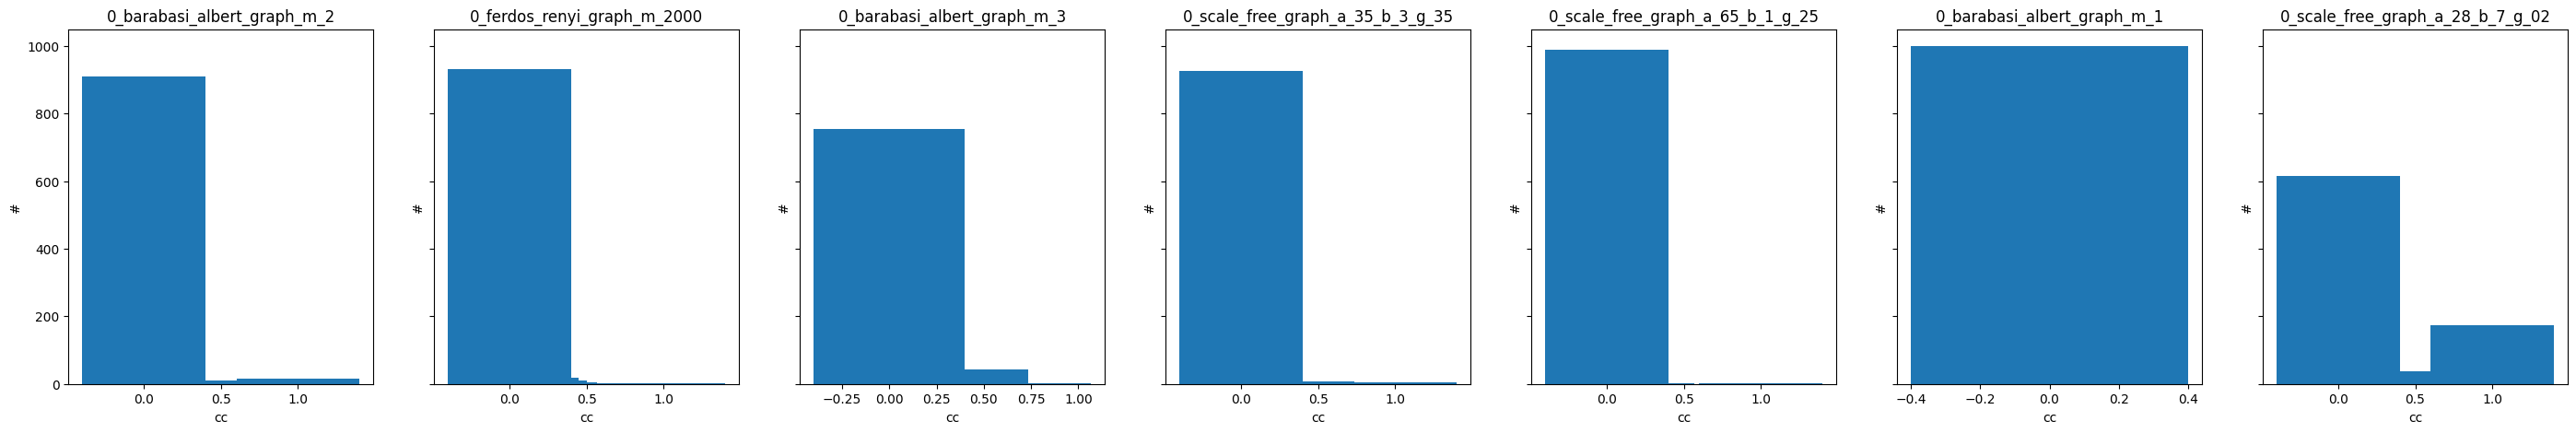

In [5]:
import matplotlib.pyplot as plt
from collections import defaultdict


fig, axes = plt.subplots(1, len(g_ps), figsize=(5 * len(g_ps), 5), sharey=True)


for i, g_p in enumerate(g_ps):
    ax = axes[i]
    
    g = nx.read_edgelist(OUT / g_p)
    
    cc = defaultdict(lambda: 0)
    for _, n_cc in nx.clustering(g).items():
        cc[n_cc] += 1

    ax.bar(cc.keys(), cc.values())
    ax.set_title(g_p)
    
    ax.set_xlabel("cc")
    ax.set_ylabel("#")
   

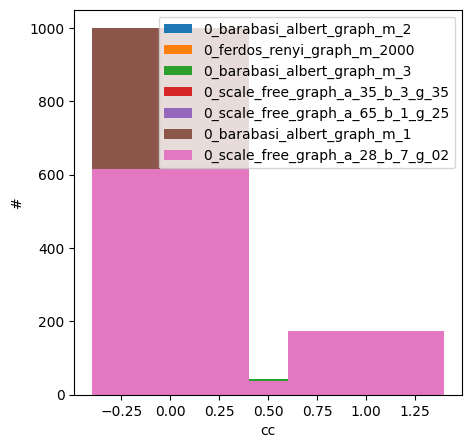

In [10]:
import matplotlib.pyplot as plt
from collections import defaultdict


fig, ax = plt.subplots(1, 1, figsize=(5,5))


for i, g_p in enumerate(g_ps):    
    g = nx.read_edgelist(OUT / g_p)
    
    cc = defaultdict(lambda: 0)
    for _, n_cc in nx.clustering(g).items():
        cc[n_cc] += 1

    ax.bar(cc.keys(), cc.values(), label=g_p)

ax.set_xlabel("cc")
ax.set_ylabel("#")
ax.legend()
   

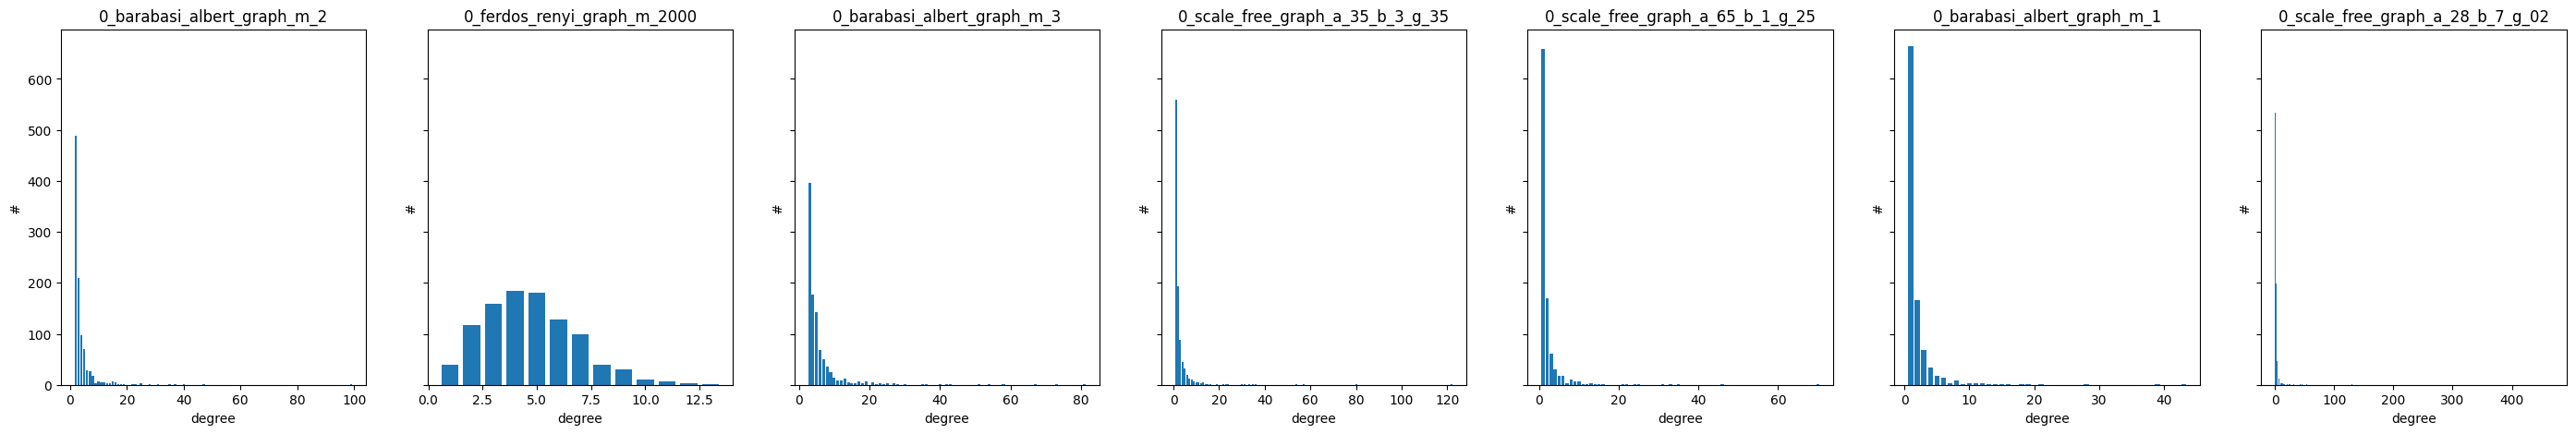

In [7]:
# Degree of a node and his neighbors
import matplotlib.pyplot as plt
from collections import defaultdict


fig, axes = plt.subplots(1, len(g_ps), figsize=(5 * len(g_ps), 5), sharey=True)


for i, g_p in enumerate(g_ps):
    ax = axes[i]
    
    g = nx.read_edgelist(OUT / g_p)
    
    degrees = defaultdict(lambda: 0)
    for n in g.nodes:
        n_neighbors = g.neighbors(n)
        
        all_neighbors = set(n_neighbors)
        for neighbor in n_neighbors:
            all_neighbors.update(g.neighbors(neighbor))
        degrees[len(all_neighbors)] += 1

    ax.bar(degrees.keys(), degrees.values())
    ax.set_title(g_p)
    
    ax.set_xlabel("degree")
    ax.set_ylabel("#")
   

In [8]:
pd.DataFrame(data).sort_values(by="name")

,name,nodes,edges,# 3 subgraphs,# 4 subgraphs
5,0_barabasi_albert_graph_m_1,1000,999,5150,51246
0,0_barabasi_albert_graph_m_2,1000,1996,19612,380109
2,0_barabasi_albert_graph_m_3,1000,2991,37123,790576
1,0_ferdos_renyi_graph_m_2000,1000,2345,10865,67098
6,0_scale_free_graph_a_28_b_7_g_02,1000,1994,208173,25258907
3,0_scale_free_graph_a_35_b_3_g_35,1000,1365,20389,606794
4,0_scale_free_graph_a_65_b_1_g_25,1000,1090,8924,131626


0_barabasi_albert_graph_m_2
3.992
144

0_ferdos_renyi_graph_m_2000
4.69
72

0_barabasi_albert_graph_m_3
5.982
657

0_scale_free_graph_a_35_b_3_g_35
2.73
315

0_scale_free_graph_a_65_b_1_g_25
2.18
24

0_barabasi_albert_graph_m_1
1.998
0

0_scale_free_graph_a_28_b_7_g_02
3.988
5184



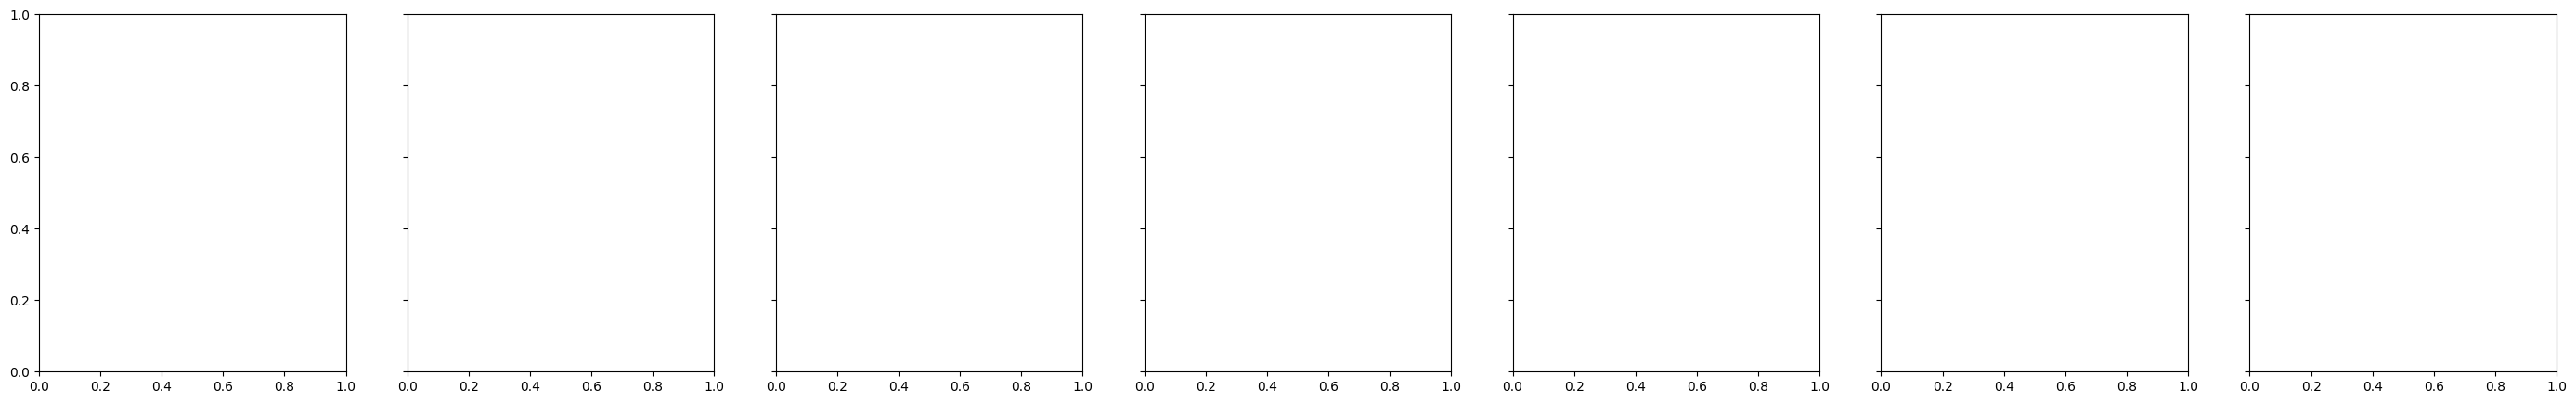

In [14]:
import matplotlib.pyplot as plt
from collections import defaultdict


fig, axes = plt.subplots(1, len(g_ps), figsize=(5 * len(g_ps), 5), sharey=True)


for i, g_p in enumerate(g_ps):
    ax = axes[i]
    
    g = nx.read_edgelist(OUT / g_p)
    
    avg_degree = dict(g.degree).values()
    avg_degree = sum(avg_degree) / len(avg_degree)
    print(g_p)
    print(avg_degree)
    print()
    print()

In [15]:
g_1 = nx.read_edgelist(OUT/"0_scale_free_graph_a_28_b_7_g_02")

g_2 = nx.read_edgelist(OUT/"0_scale_free_graph_a_35_b_3_g_35")


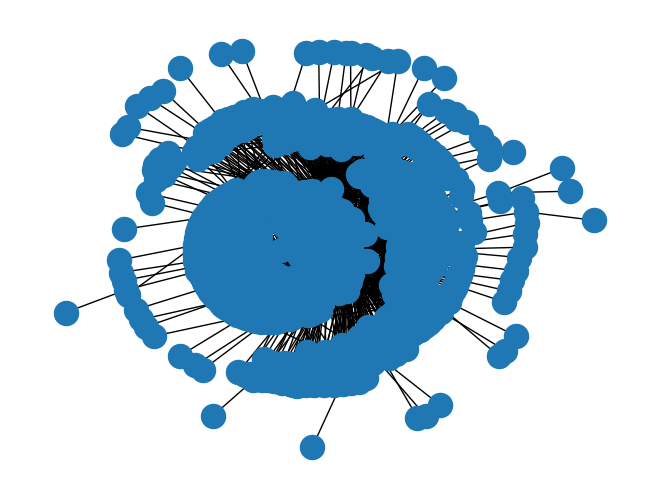

In [18]:
pos = nx.kamada_kawai_layout(g_1)
nx.draw(g_1, pos=pos)

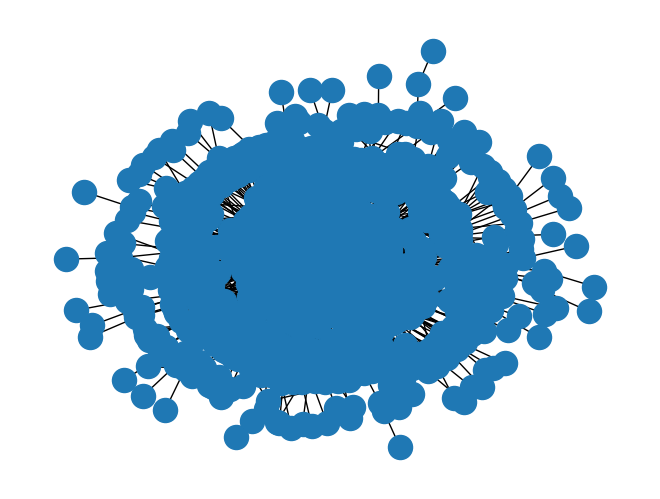

In [20]:
pos_2 = nx.kamada_kawai_layout(g_2)
nx.draw(g_2, pos=pos_2)

# PREDICTION OVER CLIQUE COUNT?

In [39]:
data

[{'name': '0_barabasi_albert_graph_m_2',
  'nodes': 1000,
  'edges': 1996,
  '# 3 subgraphs': 19612,
  '# 4 subgraphs': 380109},
 {'name': '0_ferdos_renyi_graph_m_2000',
  'nodes': 1000,
  'edges': 2345,
  '# 3 subgraphs': 10865,
  '# 4 subgraphs': 67098},
 {'name': '0_barabasi_albert_graph_m_3',
  'nodes': 1000,
  'edges': 2991,
  '# 3 subgraphs': 37123,
  '# 4 subgraphs': 790576},
 {'name': '0_scale_free_graph_a_35_b_3_g_35',
  'nodes': 1000,
  'edges': 1365,
  '# 3 subgraphs': 20389,
  '# 4 subgraphs': 606794},
 {'name': '0_scale_free_graph_a_65_b_1_g_25',
  'nodes': 1000,
  'edges': 1090,
  '# 3 subgraphs': 8924,
  '# 4 subgraphs': 131626},
 {'name': '0_barabasi_albert_graph_m_1',
  'nodes': 1000,
  'edges': 999,
  '# 3 subgraphs': 5150,
  '# 4 subgraphs': 51246},
 {'name': '0_scale_free_graph_a_28_b_7_g_02',
  'nodes': 1000,
  'edges': 1994,
  '# 3 subgraphs': 208173,
  '# 4 subgraphs': 25258907}]

In [47]:
df = pd.DataFrame(data).sort_values(by="name")

In [48]:
c3s = []
c4s = []
for g_p in df["name"]:
    g = nx.read_edgelist(OUT / g_p)
    cliques = list(nx.enumerate_all_cliques(g))
    c3 = len([c for c in cliques if len(c) == 3])
    c4 = len([c for c in cliques if len(c) == 4])
    
    c3s.append(c3)
    c4s.append(c4)
    
df["# 3-Clique"] = c3s
df["# 4-Clique"] = c4s

df

,name,nodes,edges,# 3 subgraphs,# 4 subgraphs,# 3-Clique,# 4-Clique
5,0_barabasi_albert_graph_m_1,1000,999,5150,51246,0,0
0,0_barabasi_albert_graph_m_2,1000,1996,19612,380109,48,0
2,0_barabasi_albert_graph_m_3,1000,2991,37123,790576,219,8
1,0_ferdos_renyi_graph_m_2000,1000,2345,10865,67098,24,0
6,0_scale_free_graph_a_28_b_7_g_02,1000,1994,208173,25258907,1728,1437
3,0_scale_free_graph_a_35_b_3_g_35,1000,1365,20389,606794,105,10
4,0_scale_free_graph_a_65_b_1_g_25,1000,1090,8924,131626,8,0


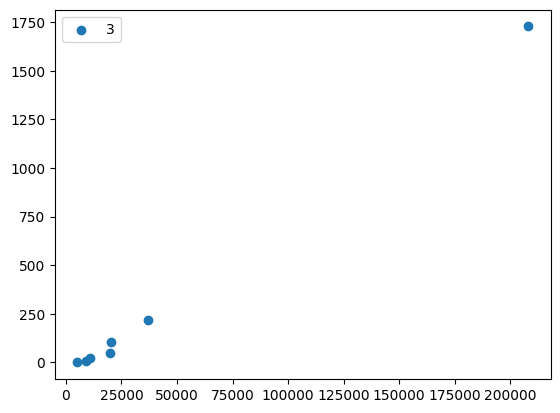

In [52]:
plt.scatter(
    df["# 3 subgraphs"],
    df["# 3-Clique"],
    label="3"
)

plt.legend()

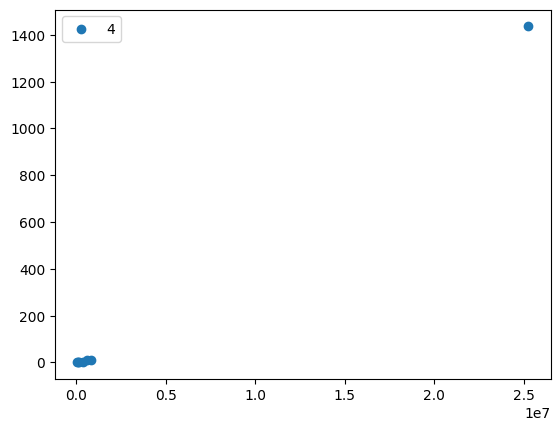

In [53]:
plt.scatter(
    df["# 4 subgraphs"],
    df["# 4-Clique"],
    label="4"
)
plt.legend()

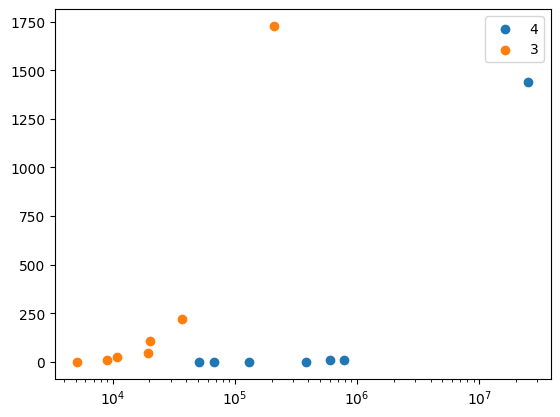

In [54]:
plt.scatter(
    df["# 4 subgraphs"],
    df["# 4-Clique"],
    label="4"
)

plt.scatter(
    df["# 3 subgraphs"],
    df["# 3-Clique"],
    label="3"
)

plt.legend()

plt.xscale("log")